# Haxby Dataset Visual Stimuli Classification

Nilearn is an extensive library uses multidisciplinary approach to fMRI and machine learning. In this tutorial we will use Haxby dataset which has different images shown to the participants and in this example we use the mask to predict the visual stimuli presented. Source: https://nilearn.github.io/dev/auto_examples/07_advanced/plot_advanced_decoding_scikit.html


### We firstly initialise the first checks and plot the Region of Interest (ROI)

First subject functional nifti images (4D) are at: /Users/yillysaurus/nilearn_data/haxby2001/subj2/bold.nii.gz


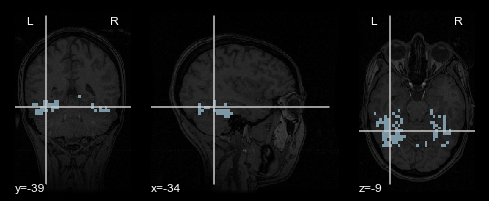

In [68]:
import numpy as np
import scipy as sc
import nilearn as ni
import pandas as pd
import sklearn as sk




from nilearn import datasets
import warnings
warnings.filterwarnings('ignore')
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)

from nilearn import plotting
from nilearn.image import mean_img
plotting.view_img(mean_img(fmri_filename), threshold=None)




mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')


=> The anatomical images appear as not preprocessed. However, as we will only require the functional images for this task, we will not go through skull stripping or brain extraction.
-------------


# Preprocessing

One of the most important files in assessing any fMRI experiment is the behavioural .csv file which is encoded with the stimuli labels and -in some cases- the time series information.

In [69]:
behavioural = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(behavioural)

     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


-> In this example, we only extract the labels column as the visual stimuli would be our target variable. In order to simplify, we only choose two visual stimuli as face and cat but in the .csv file, we actually have 9 different stimuli presented to the subjects.

In [70]:
conditions = behavioural['labels']


condition_mask = conditions.isin(['face', 'cat'])
conditions.unique()

array(['rest', 'scissors', 'face', 'cat', 'shoe', 'house', 'scrambledpix',
       'bottle', 'chair'], dtype=object)

At last, we index the images with the two condition stimuli we have chosen.
We also convert the conditions to a numpy array in order to be able to feed it to our decoder (machine learning model) later on.

In [71]:
from nilearn.image import index_img
fmri_niimgs = index_img(fmri_filename, condition_mask)

conditions = conditions[condition_mask]
# Convert to numpy array
conditions = conditions.values
print(conditions.shape)


(216,)


## Model (Decoder) Application with Cross Validation

As we have not manually separated the data as training and set and we experiment with cross validation.

In [90]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from nilearn.decoding import Decoder

cv= LeaveOneGroupOut()
cv2=LeaveOneOut()
cv3=KFold(shuffle=True, random_state=42)
decoder_onegroup = Decoder(estimator='svc', mask=mask_filename, standardize=True,cv=cv, scoring="f1")
decoder_one = Decoder(estimator='svc', mask=mask_filename, standardize=True,cv=cv2, scoring="f1")
decoder_kfold = Decoder(estimator='svc', mask=mask_filename, standardize=True,cv=cv3, scoring="f1")

Note: We define three models with different cross validation strategies to look at the accuracy of each. For the scoring, the F1 score combines precision and recall into one metric. This is the harmonic mean of precision and recall, and is probably the most used metric for evaluating binary classification models.

In [91]:
session_label = behavioral['chunks'][condition_mask]
decoder_onegroup.fit(fmri_niimgs, conditions,groups=session_label)
decoder_one.fit(fmri_niimgs, conditions,groups=session_label)
decoder_kfold.fit(fmri_niimgs, conditions,groups=session_label)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this beh

In [92]:
decoder_onegroup.predict(fmri_niimgs)
decoder_one.predict(fmri_niimgs)
decoder_kfold.predict(fmri_niimgs)
#print(decoder.score(conditions,prediction))
import numpy as np

print("SVC accuracy with Leave One Group Out: {:.3f}".format(np.mean(list(decoder_onegroup.cv_scores_.values()))))
print("SVC accuracy with Leave One Out: {:.3f}".format(np.mean(list(decoder_one.cv_scores_.values()))))
print('----------------------------------------')
print(">Winner: SVC accuracy with K Fold: {:.3f}<".format(np.mean(list(decoder_kfold.cv_scores_.values()))))
print('----------------------------------------')

SVC accuracy with Leave One Group Out: 0.701
SVC accuracy with Leave One Out: 0.463
----------------------------------------
>Winner: SVC accuracy with K Fold: 0.925<
----------------------------------------


## Conclusion

Especially with K Fold, it is imperative to use shuffle as a parameter as normally train test split has this as default which drastically changes the accuracy score. The only mishap of the decoder is the limited usability of evaluation metrics, the only viable metric is Cross validation scores.


-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•--•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•
Easter Egg: Did you know where *random_state=42* random state number 42 comes from?
If you would guess as it is due to an algebra calculation, that is an overshoot. Apparently the number that the random state hyperparameter does not have that much of a distinction as long as it is an integer.
And I quote:
"42 is a reference from Hitchhikers guide to galaxy book. The answer to life universe and everything and is meant as a joke. It has no other significance."
-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•--•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•-•
